ShapeDetection

Based on __[jrieke / shape-detection](https://github.com/jrieke/shape-detection/blob/master/single-rectangle.ipynb)__

In [1]:
import numpy as np

img_size = 8
min_object_size = 1
max_object_size = 4

def make_image(img):
    if np.random.rand(1) <= 0.2:
        exists = 0.0
        bbox = [0.0, 0.0, 0.0, 0.0]
    else:
        exists = 1.0
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        img[x:x+w, y:y+h] = 1.  # set rectangle to 1
        bbox = [x, y, w, h]
    return (exists, bbox)

In [2]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0
exists = np.zeros((num_imgs, 1))
bboxes = np.zeros((num_imgs, 4))   # x, y, w, h

for i_img in range(num_imgs):
    exists[i_img], bboxes[i_img] = make_image(imgs[i_img])
    
# print(imgs[0])
# print(exists[0])
# print(bboxes[0])

In [3]:
# Reshape to match the input shape of the neural network.
X = imgs.reshape(num_imgs, -1)
X.shape

(50000, 64)

In [4]:
def split_train_test(data):
    i = int(0.8 * num_imgs)
    train_data = data[ :i ]
    test_data = data[ i: ]
    return (train_data, test_data)

In [5]:
# Split training and test.
train_X, test_X = split_train_test(X)
train_y_exists, test_y_exists = split_train_test(exists)
train_y_bboxes, test_y_bboxes = split_train_test(bboxes)
train_imgs, test_imgs = split_train_test(imgs)

In [6]:
from keras.losses import binary_crossentropy, mean_absolute_error
import tensorflow as tf

y_loss_true_exists = None
    
def exists_loss(y_true, y_pred):
    global y_loss_true_exists
    y_loss_true_exists = y_true[ : , 0]
    return binary_crossentropy(y_true, y_pred)

def bboxes_loss(y_true, y_pred):
    global y_loss_true_exists
    return y_loss_true_exists * mean_absolute_error(y_true, y_pred)

Using TensorFlow backend.


In [7]:
from keras.metrics import binary_accuracy

y_acc_true_exists = None
y_acc_pred_exists = None

def exists_acc(y_true, y_pred):
    global y_acc_true_exists, y_acc_pred_exists
    y_acc_true_exists = y_true[ : , 0]
    y_acc_pred_exists = y_pred[ : , 0]
    return binary_accuracy(y_true, y_pred)

def bboxes_acc_iou(y_true, y_pred):
    x1, y1, w1, h1 = y_true[ : , 0], y_true[ : , 1], y_true[ : , 2], y_true[ : , 3] 
    x2, y2, w2, h2 = y_pred[ : , 0], y_pred[ : , 1], y_pred[ : , 2], y_pred[ : , 3]
    zeros = tf.zeros_like(x1)
    
    w_I =  tf.maximum(zeros, tf.minimum(x1 + w1, x2 + w2) - tf.maximum(x1, x2))
    h_I =  tf.maximum(zeros, tf.minimum(y1 + h1, y2 + h2) - tf.maximum(y1, y2))

    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

def bboxes_acc(y_true, y_pred):
    global y_acc_true_exists, y_acc_pred_exists

    zeros = tf.zeros_like(y_acc_true_exists)
    ones = tf.ones_like(y_acc_true_exists)

    both_not_exists = tf.logical_and(
        tf.less(y_acc_true_exists, 0.5), tf.less(y_acc_pred_exists, 0.5))
    acc_1 = tf.where(both_not_exists, ones, zeros)

    both_exists = tf.logical_and(
        tf.greater_equal(y_acc_true_exists, 0.5), tf.greater_equal(y_acc_pred_exists, 0.5))
    acc_2 = tf.where(both_exists, bboxes_acc_iou(y_true, y_pred), acc_1)
    
    return acc_2

1 つ目の Dense
  - 入力が 64
  - ニューロンが 200
  - ウエイトの数は 64 x 200 = 12,800、バイアスが 200、パラメータ数の合計は 12,800 + 200 = 13,000。

2 つ目の Dense
  - 入力が 200
  - ニューロンが 5
  - ウエイトの数は 200 x 5 = 1,000、バイアスが 5、パラメータ数の合計は 1,000 + 5 = 1,005。

In [8]:
# Build the model.
from keras.models import Model
from keras.layers import Input, Dense, Dropout
# from keras.optimizers import SGD

inputs = Input(shape=(X.shape[-1], ), name='Input')
x = Dense(200, activation='relu', name='Dense_1')(inputs)
x = Dropout(0.2, name='Dropout_1')(x)
exists = Dense(1, activation='sigmoid', name='exists')(x)
bbox = Dense(4, activation='linear', name='bbox')(x)

model = Model(inputs=inputs, outputs=[exists, bbox])
model.compile(
    'adadelta', 
    loss={'exists': exists_loss, 'bbox': bboxes_loss},
    metrics={'exists': exists_acc, 'bbox': bboxes_acc})
    # loss={'exists': 'binary_crossentropy', 'bbox': 'mean_absolute_error'})
model.summary()

W1012 13:47:40.915672  8104 deprecation_wrapper.py:119] From C:\Users\tsuda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1012 13:47:40.958557  8104 deprecation_wrapper.py:119] From C:\Users\tsuda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1012 13:47:41.006440  8104 deprecation_wrapper.py:119] From C:\Users\tsuda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1012 13:47:41.008425  8104 deprecation_wrapper.py:119] From C:\Users\tsuda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1012 13:47:41.026376  8104 deprecation.py:50

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 64)           0                                            
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 200)          13000       Input[0][0]                      
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 200)          0           Dense_1[0][0]                    
__________________________________________________________________________________________________
exists (Dense)                  (None, 1)            201         Dropout_1[0][0]                  
__________________________________________________________________________________________________
bbox (Dens

In [9]:
# Train.
model.fit(
    train_X, [train_y_exists, train_y_bboxes], epochs=10,
    validation_data=(test_X, [test_y_exists, test_y_bboxes]), verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.4422 - exists_loss: 0.0758 - bbox_loss: 0.3664 - exists_exists_acc: 0.9781 - bbox_bboxes_acc: 0.4943 - val_loss: 0.1299 - val_exists_loss: 0.0074 - val_bbox_loss: 0.1226 - val_exists_exists_acc: 1.0000 - val_bbox_bboxes_acc: 0.7353
Epoch 2/10
 - 4s - loss: 0.1742 - exists_loss: 0.0043 - bbox_loss: 0.1698 - exists_exists_acc: 1.0000 - bbox_bboxes_acc: 0.6511 - val_loss: 0.0844 - val_exists_loss: 0.0020 - val_bbox_loss: 0.0824 - val_exists_exists_acc: 1.0000 - val_bbox_bboxes_acc: 0.7805
Epoch 3/10
 - 4s - loss: 0.1456 - exists_loss: 0.0018 - bbox_loss: 0.1439 - exists_exists_acc: 1.0000 - bbox_bboxes_acc: 0.6822 - val_loss: 0.0670 - val_exists_loss: 0.0011 - val_bbox_loss: 0.0659 - val_exists_exists_acc: 1.0000 - val_bbox_bboxes_acc: 0.8327
Epoch 4/10
 - 4s - loss: 0.1351 - exists_loss: 0.0011 - bbox_loss: 0.1340 - exists_exists_acc: 1.0000 - bbox_bboxes_acc: 0.6961 - val_loss: 0.0561 - val_exists_loss: 7.5414e

In [10]:
# Predict bounding boxes existance and the location on the test images.
pred_exists, pred_bboxes = model.predict(test_X)

In [11]:
def IOU(exists1, exists2, bbox1, bbox2):
    '''
    Calculate overlap between two bounding boxes [x, y, w, h]
    as the area of intersection over the area of unity
    '''
    if 0.5 <= exists1 and 0.5 <= exists2:
        x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
        x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

        w_I = max(0.0, min(x1 + w1, x2 + w2) - max(x1, x2))
        h_I = max(0.0, min(y1 + h1, y2 + h2) - max(y1, y2))

        I = w_I * h_I
        U = w1 * h1 + w2 * h2 - I

        return I / U
    else:
        if exists1 < 0.5 and exists2 < 0.5:
            return 1.0
        else:
            return 0.0

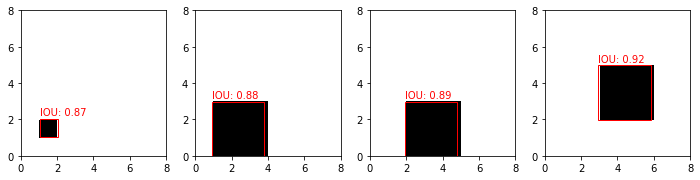

In [12]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(
        test_imgs[i].T, cmap='Greys', interpolation='none',
        origin='lower', extent=[0, img_size, 0, img_size])
    pred_bbox, test_bbox, pred_exist, test_exist = \
            pred_bboxes[i], test_y_bboxes[i], pred_exists[i], test_y_exists[i]
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
    iou = IOU(pred_exist, test_exist, pred_bbox, test_bbox)
    plt.annotate(
        'IOU: {:.2f}'.format(iou),
        (max(0.0, pred_bbox[0]), pred_bbox[1]+pred_bbox[3]+0.2), color='r')

plt.show()
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [13]:
# Calculate the mean IOU (overlap) between the predicted and expected
# bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox, pred_exist, test_exist in \
        zip(pred_bboxes, test_y_bboxes, pred_exists, test_y_exists):
    summed_IOU += IOU(pred_exist, test_exist, pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print("Mean IOU: {0:.3f}".format(mean_IOU))

Mean IOU: 0.882
